In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [424]:
crypto = pd.read_csv('S&P Cryptocurrency Broad Digital Markeet (BDM) Index.csv', index_col='Date', parse_dates=True)
crypto.columns = ['Crypto']

stocks = pd.read_csv('S&P 500.csv', index_col='Date', parse_dates=True)
stocks.columns = ['Stocks']

commodity = pd.read_csv('Dow Jones Commodity Index.csv', index_col='Date', parse_dates=True)
commodity.columns = ['Commodity']

fx = pd.read_csv('Trade-Weighted US Dollar Index.csv', index_col='Date', parse_dates=True)
fx.columns = ['FX']

bond = pd.read_csv('S&P US Aggregate  Bond Index.csv', index_col='Date', parse_dates=True)
bond.columns = ['Bond']

data = pd.concat([crypto, stocks, commodity, fx, bond], axis=1)
data = data.interpolate(method='time', axis=0)
data = data.dropna()

In [329]:
returns = np.log(data / data.shift(1)).dropna()

cumulative_returns = np.exp(returns.cumsum())
cumulative_returns.iloc[0] = 1

## Assets Profiles

In [330]:
freq = 252
rf = 0.0433

### Avg, Std, Sharpe, MDD, Weeks to recovery

In [384]:
avg_return = np.exp(returns.mean()) - 1 # Daily
avg_return = ((1 + avg_return) ** 252 - 1) # Yearly

std = returns.std() * np.sqrt(252)

sharpe = (avg_return - rf) / std

dd = cumulative_returns / cumulative_returns.cummax() - 1 # Drawdown
mdd = dd.min()

recovery_list = {}
for column in dd.columns:
    asset_dd = dd[column]
    mdd_date = asset_dd.idxmin()
    mdd_peak_val = cumulative_returns[column].cummax().loc[mdd_date]
    mdd_after = cumulative_returns[column].loc[mdd_date:]
    recovered = mdd_after[mdd_after >= mdd_peak_val]
    if not recovered.empty:
        recovery_date = recovered.index[0]
        recovery_weeks = (recovery_date - mdd_date).days // 7
    else:
        recovery_weeks = None

    recovery_list[column] = recovery_weeks

recovery_list = pd.Series(recovery_list)

In [385]:
summary = pd.DataFrame({'Avg Return': avg_return, 'Std Dev': std, 'Sharpe': sharpe, 'MDD': mdd, 'Weeks to Recovery': recovery_list})
display(summary)

,Avg Return,Std Dev,Sharpe,MDD,Weeks to Recovery
Crypto,0.647505,0.709595,0.851479,-0.868274,107.0
Stocks,0.117122,0.183584,0.402114,-0.339250,21.0
Commodity,0.076156,0.150778,0.217907,-0.350116,29.0
FX,0.013767,0.046842,-0.630481,-0.123807,68.0
Bond,0.011941,0.042827,-0.732210,-0.168905,NaN


## Asset Correlation

In [333]:
corr = returns.corr()
print(corr)

             Crypto    Stocks  Commodity        FX      Bond
Crypto     1.000000  0.257542   0.131687 -0.153624  0.020800
Stocks     0.257542  1.000000   0.307657 -0.316777 -0.025066
Commodity  0.131687  0.307657   1.000000 -0.377861 -0.023577
FX        -0.153624 -0.316777  -0.377861  1.000000 -0.249705
Bond       0.020800 -0.025066  -0.023577 -0.249705  1.000000


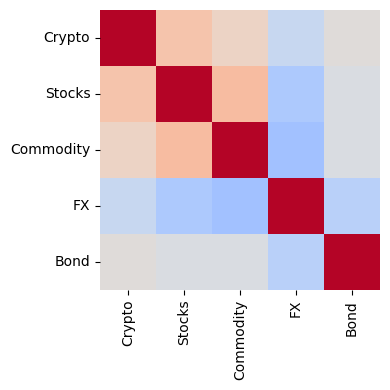

In [334]:
plt.figure(figsize=(4, 4))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, center=0, cbar=False, annot=False)
plt.tight_layout()
plt.show()

## Asset Allocation

In [362]:
def portfolio_variance(w, cov):
    return w @ cov @ w

def get_weights(mu, cov, target_mu=None):
    n = len(mu)
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    if target_mu is not None:
        constraints.append({'type': 'eq', 'fun': lambda w: w @ mu - target_mu})
    bounds = [(0, None)] * n
    initial_weights = np.ones(n) / n
    result = minimize(portfolio_variance, initial_weights, args=(cov,), 
                      constraints=constraints, bounds=bounds)
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization did not converge")

def gmvp_weight(mu, cov):
    return get_weights(mu, cov)

def mvp_weight(mu, cov, target_mu):
    return get_weights(mu, cov, target_mu)

def tangency_portfolio(mu, cov, rf):
    excess_returns = mu - rf
    n = len(mu)
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    
    bounds = [(0, None)] * n
    
    initial_weights = np.ones(n) / n
    
    def neg_sharpe_ratio(w):
        portfolio_return = np.dot(w, excess_returns)
        portfolio_volatility = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        return -portfolio_return / portfolio_volatility
    
    result = minimize(neg_sharpe_ratio, initial_weights, 
                      bounds=bounds, constraints=constraints)
    
    if not result.success:
        raise ValueError('Optimization did not coverage')
    
    weights = result.x

    portfolio_return = np.dot(weights, mu)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility

    summary = np.array([portfolio_return, portfolio_volatility, sharpe_ratio, *weights])
    return summary


### Including CCs

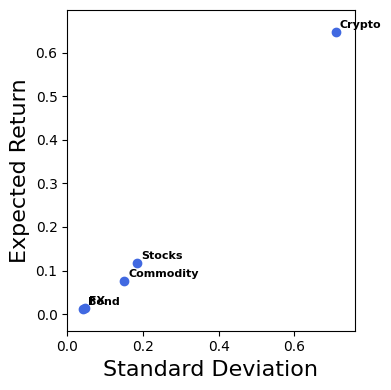

In [363]:
mu = avg_return.copy()
cov = returns.cov() * 252
std = np.sqrt(np.diag(cov))

plt.figure(figsize=(4, 4))
plt.scatter(std, mu, c='royalblue', label='Assets')
for symbol, s, m in zip(mu.index, std, mu):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std.max() + 0.05)
plt.ylim(mu.min() - 0.05, mu.max() + 0.05)
plt.tight_layout()
plt.savefig('Asset Allocation_Individual Assets.png', dpi=144, transparent=True)
plt.show()

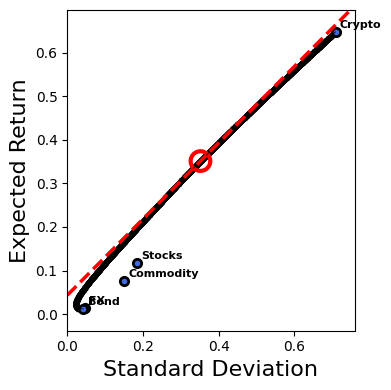

In [377]:
mu_targets = np.linspace(mu.min(), mu.max(), 1000)

portfolio_weights = [mvp_weight(mu, cov, target) for target in mu_targets]
portfolio_mu = [w @ mu for w in portfolio_weights]
portfolio_std = [np.sqrt(w @ cov @ w) for w in portfolio_weights]

# # GMVP
# gmvp = gmvp_weight(mu, cov)
# gmvp_mu = gmvp @ mu
# gmvp_std = np.sqrt(gmvp @ cov @ gmvp)

sharpe_ratios = (np.array(portfolio_mu) - rf) / np.array(portfolio_std)
max_sharpe_index = sharpe_ratios.argmax()
tangency_return = portfolio_mu[max_sharpe_index]
tangency_risk = portfolio_std[max_sharpe_index]

cal_x = np.linspace(0, max(portfolio_std), 100)
cal_x = np.linspace(0, 1, 1000)
cal_y = rf + sharpe_ratios[max_sharpe_index] * cal_x

plt.figure(figsize=(4, 4))

plt.scatter(portfolio_std, portfolio_mu, c='k', label='Efficient Frontier', s=10)
plt.plot(portfolio_std, portfolio_mu, color='k', linewidth=0.5)

# plt.scatter(gmvp_std, gmvp_mu, c='white', s=600, marker='*', label='GMVP', edgecolors='k', linewidth=3)

plt.scatter(std, mu, facecolors='royalblue', edgecolors='k', label='Assets', linewidths=2)

plt.plot(cal_x, cal_y, color='r', linewidth=2.5, linestyle='--', label='Capital Allocation Line (CAL)')

plt.scatter(tangency_risk, tangency_return, facecolors='none', s=200, marker='o', label='Tangency Portfolio', edgecolors='r', linewidth=3)

for symbol, s, m in zip(mu.index, std, mu):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std.max() + 0.05)
plt.ylim(mu.min() - 0.05, mu.max() + 0.05)
plt.tight_layout()
plt.show()

In [367]:
tangency_weights = pd.DataFrame(columns=(['Avg', 'Std', 'Sharpe']+mu.index.tolist()))
tangency_weight = tangency_portfolio(mu, cov, rf).round(4)
tangency_weights.loc['Including CC'] = tangency_weight
display(tangency_weights)

,Avg,Std,Sharpe,Crypto,Stocks,Commodity,FX,Bond
Including CC,0.3495,0.3504,0.874,0.4505,0.3902,0.1592,0.0,0.0


### Excluding CCs

In [368]:
data_l = data.drop(columns=['Crypto'])
returns_l = returns.drop(columns=['Crypto'])
avg_return_l = avg_return.drop('Crypto')

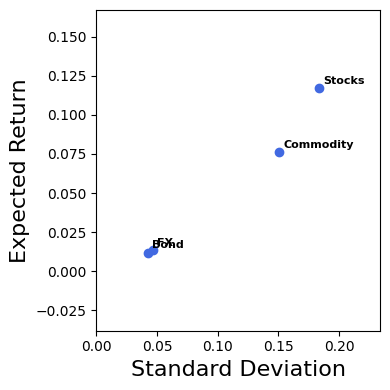

In [369]:
mu_l = avg_return_l.copy()
cov_l = returns_l.cov() * 252
std_l = np.sqrt(np.diag(cov_l))

plt.figure(figsize=(4, 4))
plt.scatter(std_l, mu_l, c='royalblue', label='Assets')
for symbol, s, m in zip(mu_l.index, std_l, mu_l):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std_l.max() + 0.05)
plt.ylim(mu_l.min() - 0.05, mu_l.max() + 0.05)
plt.tight_layout()
plt.savefig('Asset Allocation_Individual Assets.png', dpi=144, transparent=True)
plt.show()

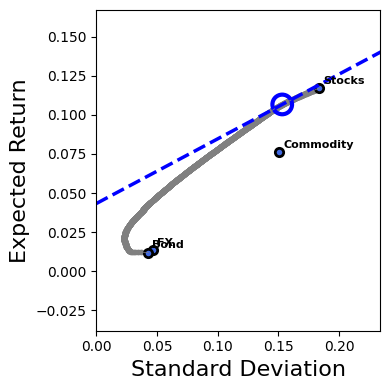

In [378]:
mu_targets_l = np.linspace(mu_l.min(), mu_l.max(), 1000)

portfolio_weights_l = [mvp_weight(mu_l, cov_l, target) for target in mu_targets_l]
portfolio_mu_l = [w @ mu_l for w in portfolio_weights_l]
portfolio_std_l = [np.sqrt(w @ cov_l @ w) for w in portfolio_weights_l]

# # GMVP
# gmvp = gmvp_weight(mu, cov)
# gmvp_mu = gmvp @ mu
# gmvp_std = np.sqrt(gmvp @ cov @ gmvp)

sharpe_ratios_l = (np.array(portfolio_mu_l) - rf) / np.array(portfolio_std_l)
max_sharpe_index_l = sharpe_ratios_l.argmax()
tangency_return_l = portfolio_mu_l[max_sharpe_index_l]
tangency_risk_l = portfolio_std_l[max_sharpe_index_l]

cal_x_l = np.linspace(0, max(portfolio_std_l), 1000)
cal_x_l = np.linspace(0, 1, 1000)
cal_y_l = rf + sharpe_ratios_l[max_sharpe_index_l] * cal_x_l

plt.figure(figsize=(4, 4))

plt.scatter(portfolio_std_l, portfolio_mu_l, c='gray', label='Efficient Frontier', s=10)
plt.plot(portfolio_std_l, portfolio_mu_l, color='gray', linewidth=0.5)

# plt.scatter(gmvp_std, gmvp_mu, c='white', s=600, marker='*', label='GMVP', edgecolors='k', linewidth=3)

plt.scatter(std_l, mu_l, facecolors='royalblue', edgecolors='k', label='Assets', linewidths=2)

plt.plot(cal_x_l, cal_y_l, color='b', linewidth=2.5, linestyle='--', label='Capital Allocation Line (CAL)')

plt.scatter(tangency_risk_l, tangency_return_l, facecolors='none', s=200, marker='o', label='Tangency Portfolio', edgecolors='b', linewidth=3)

for symbol, s, m in zip(mu_l.index, std_l, mu_l):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std_l.max() + 0.05)
plt.ylim(mu_l.min() - 0.05, mu_l.max() + 0.05)
plt.tight_layout()
plt.show()

In [379]:
tangency_weight_l = tangency_portfolio(mu_l, cov_l, rf).round(4)
tangency_weight_l = np.insert(tangency_weight_l, 3, np.nan)
tangency_weights.loc['Excluding CC'] = tangency_weight_l

display(tangency_weights)

,Avg,Std,Sharpe,Crypto,Stocks,Commodity,FX,Bond
Including CC,0.3495,0.3504,0.8740,0.4505,0.3902,0.1592,0.0,0.0
Excluding CC,0.1067,0.1530,0.4141,NaN,0.7446,0.2554,0.0,0.0


### Merge

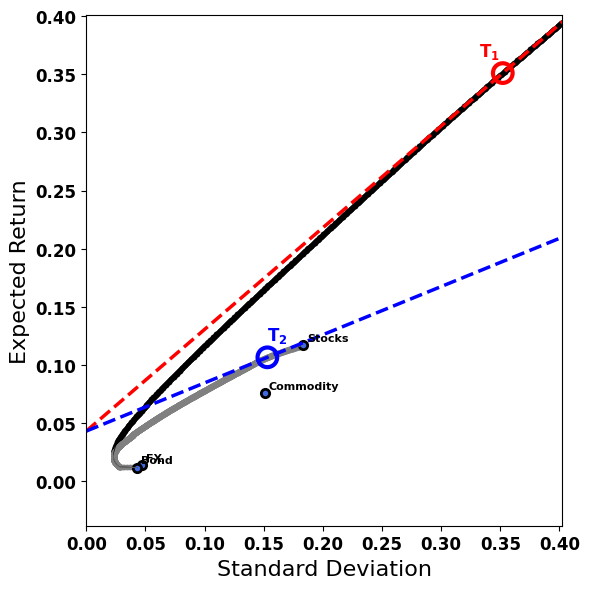

In [416]:
plt.figure(figsize=(6, 6))

plt.scatter(portfolio_std, portfolio_mu, c='k', label='Efficient Frontier', s=10)
plt.plot(portfolio_std, portfolio_mu, color='k', linewidth=0.5)

plt.scatter(portfolio_std_l, portfolio_mu_l, c='gray', label='Efficient Frontier', s=10)
plt.plot(portfolio_std_l, portfolio_mu_l, color='gray', linewidth=0.5)

plt.scatter(std, mu, facecolors='royalblue', edgecolors='k', label='Assets', linewidths=2)

plt.plot(cal_x, cal_y, color='r', linewidth=2.5, linestyle='--', label='Capital Allocation Line (CAL)')
plt.plot(cal_x_l, cal_y_l, color='b', linewidth=2.5, linestyle='--', label='Capital Allocation Line (CAL)')

plt.scatter(tangency_risk, tangency_return, facecolors='none', s=200, marker='o', label='Tangency Portfolio', edgecolors='r', linewidth=3)
plt.scatter(tangency_risk_l, tangency_return_l, facecolors='none', s=200, marker='o', label='Tangency Portfolio', edgecolors='b', linewidth=3)

plt.text(tangency_risk - 0.02, tangency_return + 0.015, r'$\mathbf{T_1}$', color='r', fontsize=12, fontweight='bold')
plt.text(tangency_risk_l, tangency_return_l + 0.015, r'$\mathbf{T_2}$', color='b', fontsize=12, fontweight='bold')

for symbol, s, m in zip(mu.index, std, mu):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xticks(fontsize=12, fontweight='heavy')
plt.yticks(fontsize=12, fontweight='heavy')
plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, max(tangency_risk, tangency_risk_l) + 0.05)
plt.ylim(mu.min() - 0.05, max(tangency_return, tangency_return_l) + 0.05)
plt.tight_layout()
plt.savefig('Asset Allocation.png', dpi=144, transparent=True)
plt.show()

## Correlation Between Traditional Assets and Cryptos

In [431]:
crypto_tickers = ['BTC-USD', 'ETH-USD', 'DOGE-USD']
stock_tickers = ['^GSPC', '000001.SS', '^N225', '^STOXX50E', '^FTSE']
commodity_tickers = ['GC=F', 'SI=F', 'HG=F', 'CL=F', 'PL=F']
fx_tickers = ['EUR=X', 'JPY=X', 'CNY=X']
bond_tickers = ['^TNX']

all_tickers = crypto_tickers + stock_tickers + commodity_tickers + fx_tickers + bond_tickers

asset_classes = {
    'Crypto': crypto_tickers,
    'Stocks': stock_tickers,
    'Commodity': commodity_tickers,
    'FX': fx_tickers,
    'Bond': bond_tickers
}

start_date = data.index[0]
end_date = '2025-01-01'

In [432]:
data_2 = yf.download(all_tickers, start=start_date, end=end_date, interval='1d')['Adj Close']
data_2.index = pd.to_datetime(data_2.index)
data_2 = data_2.interpolate(method='time', axis=0)
data_2 = data_2.dropna()
data_2 = data_2.where(data_2 > 0, 1e-10)
data_2 = data_2[all_tickers]

[*********************100%%**********************]  17 of 17 completed


In [451]:
rename = {
    'BTC-USD': 'BTC',
    'ETH-USD': 'ETH',
    'DOGE-USD': 'DOGE',
    '^GSPC': 'SP500',
    '000001.SS': 'SSE',
    '^N225': 'Nikkei225',
    '^STOXX50E': 'EUStoxx50',
    '^FTSE': 'FTSE100',
    'GC=F': 'Gold',
    'SI=F': 'Silver',
    'HG=F': 'Copper',
    'CL=F': 'CrudeOil',
    'PL=F': 'Platinum',
    'EUR=X': 'EUR',
    'JPY=X': 'JPY',
    'CNY=X': 'CNY',
    '^TNX': 'US10Y'
}
data_2.rename(columns=rename, inplace=True)

In [452]:
returns_2 = np.log(data_2 / data_2.shift(1)).dropna()

cumulative_returns_2 = np.exp(returns_2.cumsum())
cumulative_returns_2.iloc[0] = 1

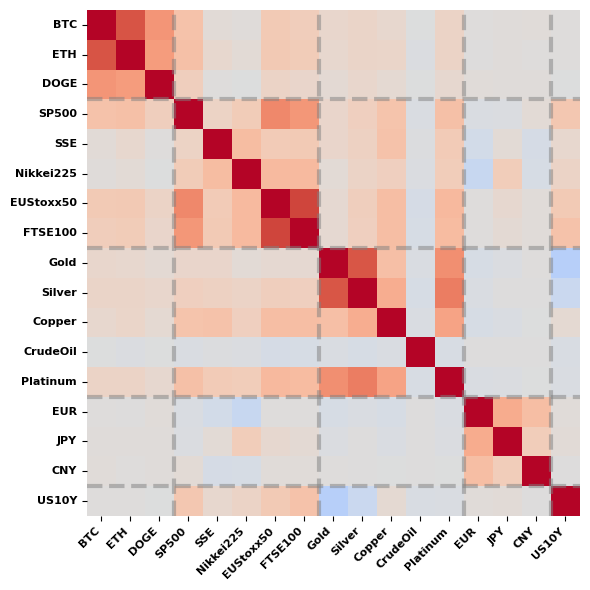

In [455]:
corr_matrix_all = returns_2.corr()

boundaries = []
start = 0
for category, tickers in asset_classes.items():
    end = start + len(tickers)
    boundaries.append((start, end))
    start = end

plt.figure(figsize=(6, 6))
sns.heatmap(
    corr_matrix_all,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    cbar=False,
    annot=False
)

for start, end in boundaries[:-1]:
    plt.axhline(y=end, color='gray', linewidth=3, linestyle='--', alpha=0.5)
    plt.axvline(x=end, color='gray', linewidth=3, linestyle='--', alpha=0.5)

plt.xticks(fontsize=8, fontweight='heavy', rotation=45, ha='right')
plt.yticks(fontsize=8, fontweight='heavy')

plt.tight_layout()
plt.savefig('Ind Corr Matrix.png', dpi=144, transparent=True)
plt.show()